In [56]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
global_temp = pd.read_csv("GlobalTemperatures.csv")
print(global_temp.shape)
print(global_temp.columns)
print(global_temp.info())
print(global_temp.isnull().sum())

(3192, 9)
Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   

In [57]:
# Data Preparation
def wrangle(df):
    df = df.copy()
    df = df.drop(columns=["LandAverageTemperatureUncertainty", "LandMaxTemperatureUncertainty",
                          "LandMinTemperatureUncertainty", "LandAndOceanAverageTemperatureUncertainty"], axis=1)
    return df  

In [58]:
# Apply the wrangle function to your DataFrame
global_temp = wrangle(global_temp)


In [59]:
def converttemp(x):
    return (x * 1.8) + 32  # Convert temperature from Celsius to Fahrenheit

# Data Preparation Continued
def wrangle(df):
    df = df.copy()
    # Convert temperature columns from Celsius to Fahrenheit
    df["LandAverageTemperature"] = df["LandAverageTemperature"].apply(converttemp)
    df["LandMaxTemperature"] = df["LandMaxTemperature"].apply(converttemp)
    df["LandMinTemperature"] = df["LandMinTemperature"].apply(converttemp)
    df["LandAndOceanAverageTemperature"] = df["LandAndOceanAverageTemperature"].apply(converttemp)
    
    # Convert 'dt' column to datetime
    df["dt"] = pd.to_datetime(df["dt"])
    
    # Extract 'Year' and 'Month' from the 'dt' column
    df["Year"] = df["dt"].dt.year
    df["Month"] = df["dt"].dt.month
    
    # Drop 'dt' column
    df = df.drop("dt", axis=1)
    
    # Filter out data for years after 1850
    df = df[df["Year"] >= 1850]
    
    # Set 'Year' as index
    df = df.set_index(["Year"])
    
    # Drop 'Month' column
    df = df.drop("Month", axis=1)
    
    # Drop rows with missing values
    df = df.dropna()
    
    return df

# Apply the wrangle function to your DataFrame
global_temp = wrangle(global_temp)
print(global_temp.head())


      LandAverageTemperature  LandMaxTemperature  LandMinTemperature  \
Year                                                                   
1850                 33.3482             46.8356             26.2292   
1850                 37.5278             49.9460             27.8762   
1850                 40.9172             50.6246             28.5710   
1850                 44.9906             55.2812             33.8324   
1850                 50.0072             60.1790             38.8598   

      LandAndOceanAverageTemperature  
Year                                  
1850                         55.0994  
1850                         56.4584  
1850                         57.2774  
1850                         58.4006  
1850                         59.9126  


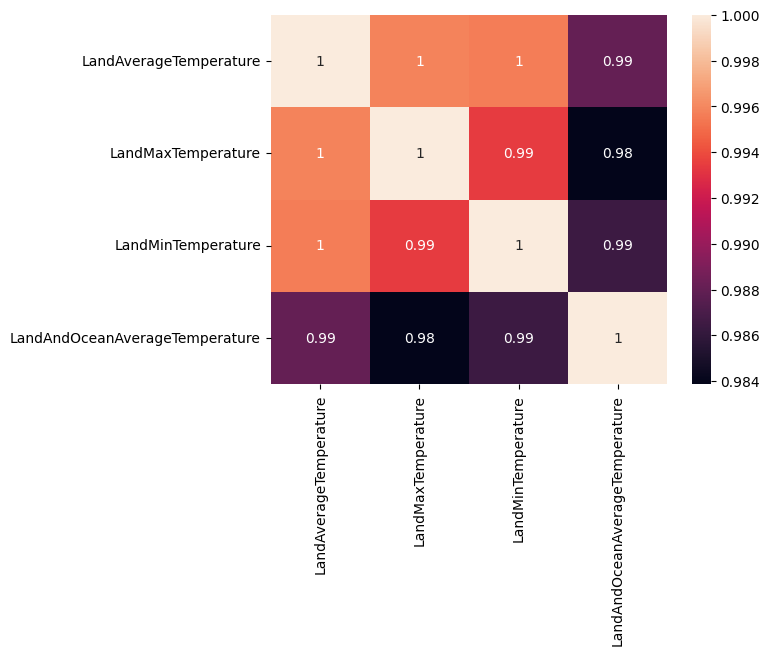

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
corrMatrix = global_temp.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

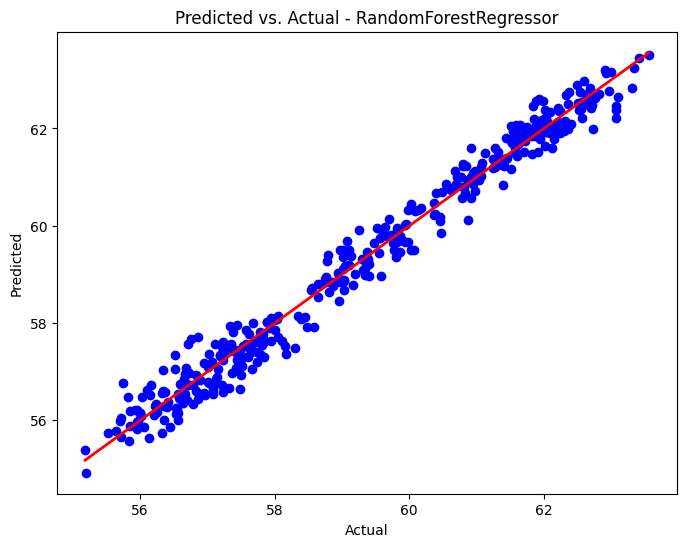

------ RandomForestRegressor ------
R²: 0.9798545506306598
Mean Absolute Error: 0.25



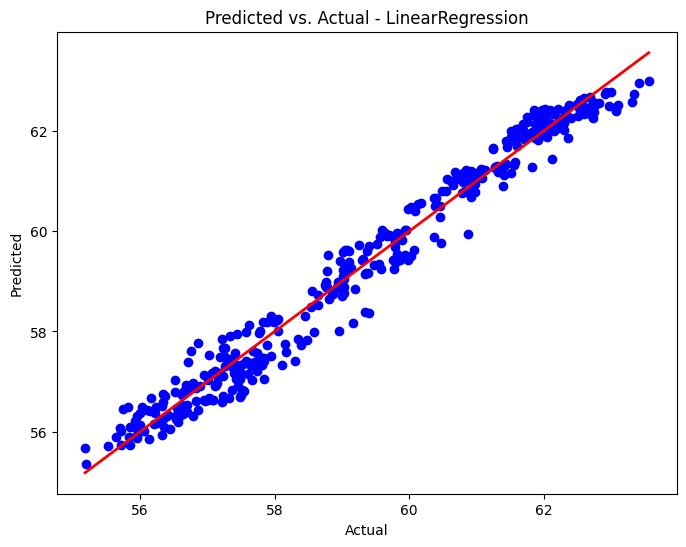

------ LinearRegression ------
R²: 0.976173149633546
Mean Absolute Error: 0.28



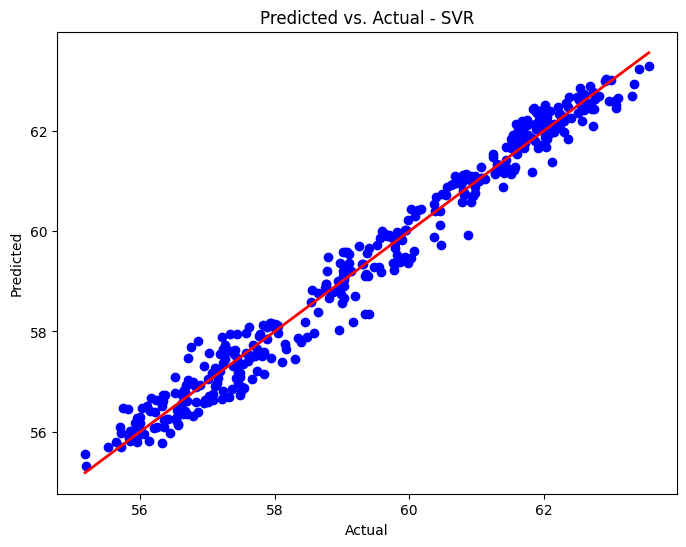

------ SVR ------
R²: 0.9776638335723183
Mean Absolute Error: 0.27



In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Laden der Daten und Vorverarbeitung
global_temp = pd.read_csv("GlobalTemperatures.csv")

def converttemp(x):
    return (x * 1.8) + 32

def wrangle(df):
    df = df.copy()
    df = df.drop(columns=["LandAverageTemperatureUncertainty", "LandMaxTemperatureUncertainty",
                          "LandMinTemperatureUncertainty", "LandAndOceanAverageTemperatureUncertainty"], axis=1)
    df["LandAverageTemperature"] = df["LandAverageTemperature"].apply(converttemp)
    df["LandMaxTemperature"] = df["LandMaxTemperature"].apply(converttemp)
    df["LandMinTemperature"] = df["LandMinTemperature"].apply(converttemp)
    df["LandAndOceanAverageTemperature"] = df["LandAndOceanAverageTemperature"].apply(converttemp)
    df["dt"] = pd.to_datetime(df["dt"])
    df["Year"] = df["dt"].dt.year
    df = df[df["Year"] >= 1850]
    df = df.set_index(["Year"])
    df = df.dropna()
    return df

global_temp = wrangle(global_temp)

# Aufteilen der Daten in Features (X) und Zielvariable (y)
target = "LandAndOceanAverageTemperature"
y = global_temp[target]
X = global_temp[["LandAverageTemperature", "LandMaxTemperature", "LandMinTemperature"]]

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definition der Modelle
models = {
    "RandomForestRegressor": RandomForestRegressor(),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(),
}

# Training, Vorhersage und Auswertung der Modelle
for name, model in models.items():
    # Erstellung des Pipelines für jedes Modell
    pipeline = make_pipeline(
        SelectKBest(k="all"),
        StandardScaler(),
        model
    )
    
    # Anpassen des Modells an die Trainingsdaten
    pipeline.fit(X_train, y_train)
    
    # Vorhersage auf den Testdaten
    y_pred = pipeline.predict(X_test)
    
    # Mean Absolute Error berechnen
    mae = mean_absolute_error(y_test, y_pred)
    
    # Bestimmtheitsmaß (R²) berechnen
    r2 = r2_score(y_test, y_pred)
    
    # Streudiagramm der Vorhersagen vs. tatsächliche Werte
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Predicted vs. Actual - {name}')
    plt.show()
    
    # Ausgabe der Ergebnisse
    print(f"------ {name} ------")
    print("R²:", r2)
    print(f"Mean Absolute Error: {mae:.2f}")
    print()


### Zusammenfassung der Modellleistung

| Modell                 | R²-Wert   | Mittlerer Absoluter Fehler |
|------------------------|-----------|-----------------------------|
| RandomForestRegressor  | 0.980     | 0.25                        |
| LinearRegression       | 0.976     | 0.28                        |
| SVR                    | 0.978     | 0.27                        |

Alle drei Modelle zeigen eine gute Leistung bei der Vorhersage der globalen Temperatur. Der RandomForestRegressor erzielt die höchste Bestimmtheit (R²) von 0.980 und den niedrigsten mittleren absoluten Fehler (MAE) von 0.25, gefolgt von SVR und LinearRegression. Die Unterschiede zwischen den R²-Werten sind gering, was darauf hinweist, dass alle Modelle eine ähnlich gute Anpassung an die Daten aufweisen.
